<h1 id="tocheading">Attrition Demo</h1>
<div id="toc"></div>

<img src="https://github.com/CatherineCao2016/pics/raw/master/header.png" width="800" height="500" align="middle"/>

The Attrition demo focuses on retaining Merchants that are using company network for credit card processing. Here is the description of the case:

A client approved many low value merchant accounts without much scrutiny.  Many of those merchant accounts resulted in default. The client thinks that they should have put more of an emphasis on their applicant screening process. IBM suggests to enable fact based decision making for performance of its joint marketing programs.

This notebook will demostrate how to

1. Use Brunel and Seaborn library for visualizations

2. Use regular python Machine Learning libary scikit-learn and Spark's Machine Learning library(MLlib) for predicitive modeling in an intergrated environment on DSX.
3. Deploy SparkML model using Machine Learning Service

## Load Libraries

Run the following cell to import required libraries.

In [4]:
import sklearn

import pandas as pd
pd.options.display.max_columns = 999

#import brunel

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json, os

## Load Customer History Data

In [5]:
cust_pd = pd.read_csv('/project_data/data_asset/customer_history.csv')
cust_pd.head()

FileNotFoundError: [Errno 2] File /project_data/data_asset/customer_history.csv does not exist: '/project_data/data_asset/customer_history.csv'

### Dataset Overview

Let's take a quick look at the dataset.

In [4]:
print ("There are " + str(len(cust_pd)) + " observations in the customer history dataset.")
print ("There are " + str(len(cust_pd.columns)) + " variables in the dataset.")

print ("\n******************Descriptive statistics*****************************\n")
print (cust_pd.describe())

print ("\n******************Dataset Quick View*****************************\n")
cust_pd.head()

There are 1000 observations in the customer history dataset.
There are 13 variables in the dataset.

******************Descriptive statistics*****************************

          MERCHANT  CONTRACT_DURATION_MONTH  AMOUNT_K_USD  ESTABLISHED_MONTH  \
count  1000.000000              1000.000000   1000.000000        1000.000000   
mean    500.500000                20.903000   3271.258000          35.546000   
std     288.819436                12.058814   2822.736876          11.375469   
min       1.000000                 4.000000    250.000000          19.000000   
25%     250.750000                12.000000   1365.500000          27.000000   
50%     500.500000                18.000000   2319.500000          33.000000   
75%     750.250000                24.000000   3972.250000          42.000000   
max    1000.000000                72.000000  18424.000000          75.000000   

       NUMBER_CREDITS   IS_DEFAULT  
count     1000.000000  1000.000000  
mean         1.407000     0.30000

,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,PRESENT_RESIDENT,ESTABLISHED_MONTH,NUMBER_CREDITS,IS_DEFAULT
0,893,0 USD,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,4,38,2,0
1,894,0 to 200 USD,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,4,34,2,0
2,895,NONE,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,above 4 YRS,29,2,0
3,896,NONE,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,2 to 3 YRS,31,1,0
4,897,0 USD,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,4,28,1,0


### AMOUNT_K_USD vs. IS_DEFAULT

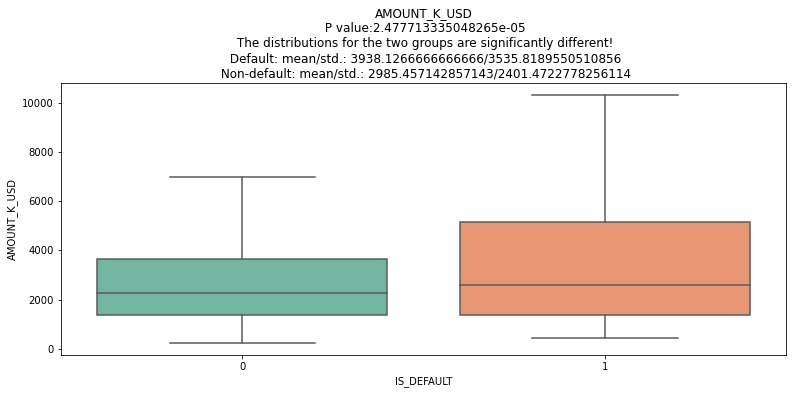

In [5]:
sub_yes = cust_pd[cust_pd["IS_DEFAULT"] == 1]
sub_no = cust_pd[cust_pd["IS_DEFAULT"] == 0]
    
p_value = ttest_ind(sub_yes['AMOUNT_K_USD'], sub_no["AMOUNT_K_USD"], equal_var = False)[1]

fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "IS_DEFAULT", y = "AMOUNT_K_USD", data = cust_pd, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))
else:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_safe["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))           

In this box plot, the visualization is enhanced by T-test statistics. The result is significant which indicates that the average credit amount for the non-default group and default group are different. Default group has larger average credit amount.



### Default rate by state

### Correlation Matrix

A heatmap is used to visualize the correlations between all continuous variables.

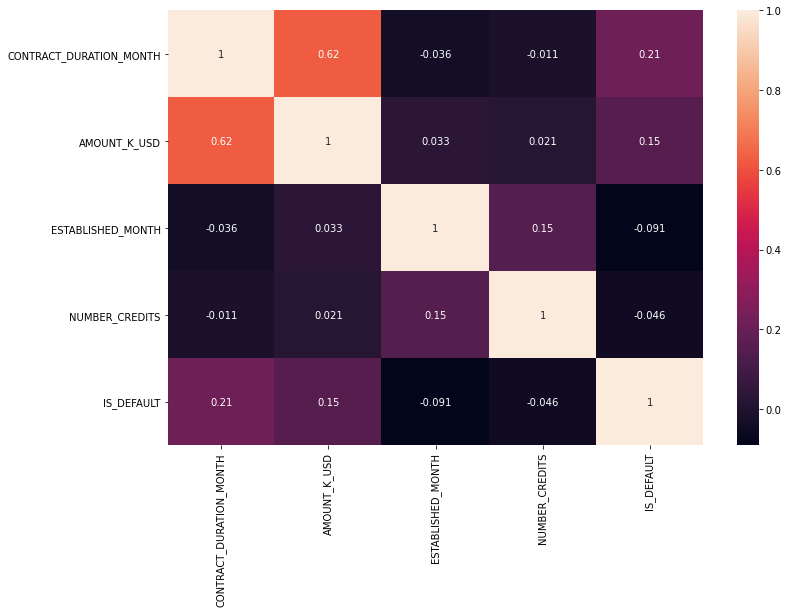

In [7]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);


* There is no strong correlation between most variables.
* The correlation between AMOUNT_K_USD and CONTRACT_DURATION_MONTH is moderate.